# Explain diamonds model

The aim of this notebook is to model diamond prices with optimized Gradient Boosting and then explain the resulting model by [SHAP](https://github.com/slundberg/shap), a concept borrowed from game theory. As such, the notebook can be used as a template for other regression situations.

## Load libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-notebook')
sns.set(context="notebook", style="whitegrid")

diamonds = sns.load_dataset("diamonds")
print("The first lines of the data set:", diamonds.head(), sep="\n")

The first lines of the data set:
   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75


## Transform data

Before describing the data, we apply some transformations.

In [5]:
from pandas.api.types import CategoricalDtype

# Function that prepares a pandas df line by line
#  -> handling of categories looks too verbose but allows (A) for safe preparation of a single line
#     and (B) for the right ordering of levels.

def transform(df):
    df = df.assign(depth=df.depth.clip(55, 70),
                   table=df.table.clip(50, 70),
                   carat=df.carat.clip(upper=3),
                   color=pd.Categorical(df.color, categories=['D', 'E', 'F', 'G', 'H', 'I', 'J']),
                   cut=pd.Categorical(df.cut, categories=['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']),
                   clarity=pd.Categorical(df.clarity, categories=['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1']))
    return df.drop(list("xyz"), axis=1)

df = transform(diamonds)

# Important variable groups
response = "price"
num_vars = ["carat", "depth", "table"]
ordinal_vars = ["color", "cut", "clarity"]
features = num_vars + ordinal_vars

## Describe data

### Univariate categorical variables

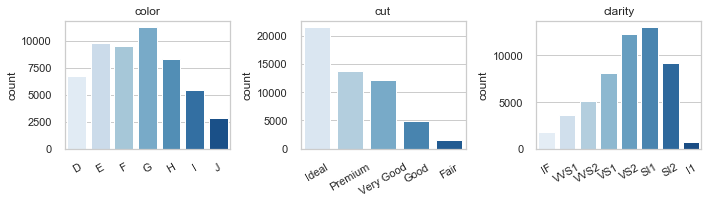

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))

for i, v in enumerate(ordinal_vars):
    sns.countplot(df[v], palette="Blues", ax=ax[i])
    ax[i].set_title(v)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=30)
    ax[i].set_xlabel("")
fig.tight_layout()

### Univariate numeric variables

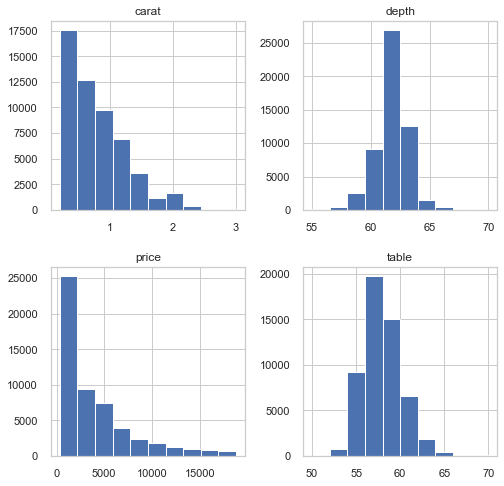

In [7]:
df[[response] + num_vars].hist(figsize=(8, 8), layout=(2, 2));

### Associations across numerics (incl. response)

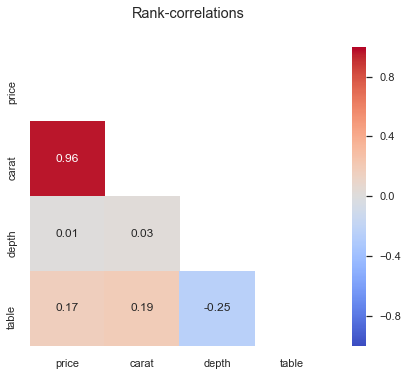

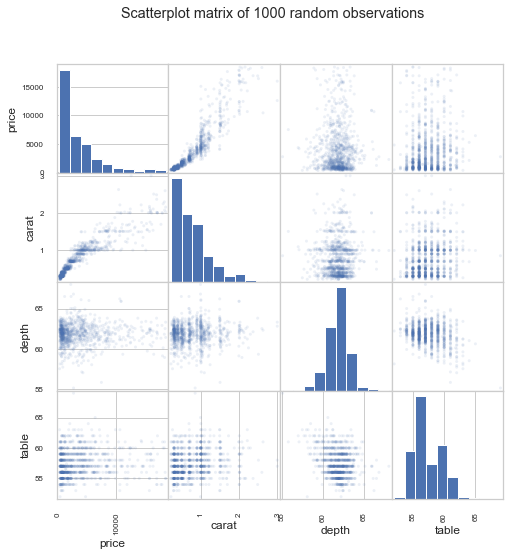

In [8]:
# Correlations
corrmat = df[[response] + num_vars].corr("spearman")
sns.heatmap(corrmat, center=0, vmin=-1, vmax=1, 
            cmap='coolwarm', annot=True, square=True,
            mask=np.triu(corrmat));
plt.suptitle('Rank-correlations')
plt.show()

# Scatter
pd.plotting.scatter_matrix(df[[response] + num_vars].sample(1000), alpha=0.1, figsize=(8, 8));
plt.suptitle('Scatterplot matrix of 1000 random observations')
plt.show()

### Associations between categorical covariables and response

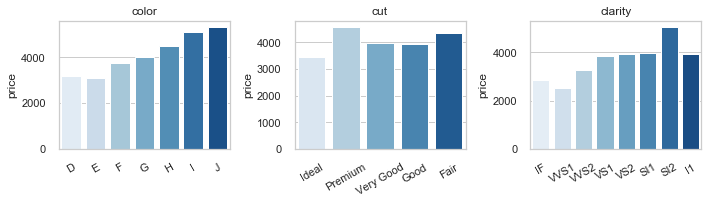

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))

for i, v in enumerate(ordinal_vars):
    sns.barplot(x=v, y=response, data=df, palette="Blues", ax=ax[i], ci=None)
    ax[i].set_title(v)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=30)
    ax[i].set_xlabel("")
fig.tight_layout()

The relationships seem the wrong way around: The better a characteristic, the lower the price. This phenomenon will vanish as soon as taking into account the size of the stones, see the last part of the notebook.

### Missing values

In [10]:
df[[response] + features].isna().sum().sort_values(ascending=False)

clarity    0
cut        0
color      0
table      0
depth      0
carat      0
price      0
dtype: int64

## Prepare data for modeling

We will model the response by [LightGBM](https://github.com/microsoft/LightGBM), an open source gradient boosting implementation by Microsoft. Since its data interface allows only numeric columns, we replace categorical variables by their order index. For interpreting the models, we keep a version of the data with the original, human readable codings.

In [11]:
# Safe way to do integer coding with Pandas
def ordinalCoder(df):
    df = df.copy()
    cats = df.select_dtypes("category").columns
    df[cats] = df[cats].apply(lambda x: x.cat.codes)
    return df
    
# Response & features
y = df[response]
X_display = df[features]

# Integer coding
X = ordinalCoder(X_display)

print("Data structure for model:", X.head(), sep="\n")
print("\nData structure for interpretation:", X_display.head(), sep="\n")

Data structure for model:
   carat  depth  table  color  cut  clarity
0   0.23   61.5   55.0      1    0        6
1   0.21   59.8   61.0      1    1        5
2   0.23   56.9   65.0      1    3        3
3   0.29   62.4   58.0      5    1        4
4   0.31   63.3   58.0      6    3        6

Data structure for interpretation:
   carat  depth  table color      cut clarity
0   0.23   61.5   55.0     E    Ideal     SI2
1   0.21   59.8   61.0     E  Premium     SI1
2   0.23   56.9   65.0     E     Good     VS1
3   0.29   62.4   58.0     I  Premium     VS2
4   0.31   63.3   58.0     J     Good     SI2


### Check preprocessing pipeline

In order to release a model in a (web-)service, it is of major importance to build a save preprocessing pipeline working also for single observations. In our case, this basically means to not mess up with wrong codings of categories.

In [12]:
step1 = transform(diamonds.head(1))
print("\nAfter transformations:\n", step1)
print("\nAfter integer codings:\n", ordinalCoder(step1))


After transformations:
    carat    cut color clarity  depth  table  price
0   0.23  Ideal     E     SI2   61.5   55.0    326

After integer codings:
    carat  cut  color  clarity  depth  table  price
0   0.23    0      1        6   61.5   55.0    326


## Modeling

We now model the response as good as possible by the prepared features. For this purpose, we use a Gradient Boosting approach. Parameters are selected by iterative GridSearch with five-fold crossvalidation on 80% training data. The final model is then evaluated on the remaining 20% test data and compared with a Random Forest baseline model. Ideally, the tuned boosted trees do better than this benchmark. 

The models are fitted by optimizing Gamma loss and evaluated by calculating root mean squared logarithmic error.

We start by splitting the data into train and test.

### Data split

In [13]:
# Data split
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

# create a train/test split
X_display_train, X_display_test, X_train, X_test, y_train, y_test = train_test_split(
    X_display, X, y, test_size=0.2, random_state=7, shuffle=True)

dtrain = lgb.Dataset(X_train, 
                     label=y_train, 
                     free_raw_data=False)

### Tune model

In [17]:
tune = False

if tune:
    from sklearn.model_selection import ParameterSampler, ParameterGrid
    
    # Final narrow grid
    grid = ParameterSampler({
        "learning_rate": [0.02],
        "num_leaves": [20, 30, 40],
        'min_child_samples': [10, 15, 20],
        'reg_alpha': [0, 1, 2],
        'reg_lambda': [0, 1],
        'min_split_gain': [0, 0.001],
        'subsample': [0.9, 1],
        'bagging_freq': [1],
        'colsample_bytree': [1],
        'colsample_bynode': [1],
        "verbose": [2],
        "objective": ["gamma"],
        "metric": ["gamma_deviance"],
        "nthread": [8] 
    }, n_iter=10)
    
    gridsearch_results = pd.DataFrame(columns=["params", "num_boost_round", "perf"])

    print("We are iterating through grid of size", len(grid))
    for g in grid:
        cv_results = lgb.cv(
            g,
            dtrain,
            num_boost_round=10000,
            nfold=5,
            stratified=False,
            early_stopping_rounds=20)
        perf = cv_results['gamma_deviance-mean']
        new_row = {"params": [g], "num_boost_round": len(perf), "perf": perf[-1]}
        print(new_row)
        gridsearch_results = gridsearch_results.append(new_row, ignore_index=True)  
        gridsearch_results.to_json("gridsearch_diamonds.txt")


We are iterating through grid of size 10
{'params': [{'verbose': 2, 'subsample': 1, 'reg_lambda': 0, 'reg_alpha': 0, 'objective': 'gamma', 'num_leaves': 20, 'nthread': 8, 'min_split_gain': 0.001, 'min_child_samples': 10, 'metric': 'gamma_deviance', 'learning_rate': 0.02, 'colsample_bytree': 1, 'colsample_bynode': 1, 'bagging_freq': 1}], 'num_boost_round': 2325, 'perf': 81.37107974227726}
{'params': [{'verbose': 2, 'subsample': 0.9, 'reg_lambda': 0, 'reg_alpha': 1, 'objective': 'gamma', 'num_leaves': 40, 'nthread': 8, 'min_split_gain': 0, 'min_child_samples': 10, 'metric': 'gamma_deviance', 'learning_rate': 0.02, 'colsample_bytree': 1, 'colsample_bynode': 1, 'bagging_freq': 1}], 'num_boost_round': 1661, 'perf': 80.455146202687}
{'params': [{'verbose': 2, 'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0, 'objective': 'gamma', 'num_leaves': 20, 'nthread': 8, 'min_split_gain': 0.001, 'min_child_samples': 10, 'metric': 'gamma_deviance', 'learning_rate': 0.02, 'colsample_bytree': 1, 'colsampl

### Load best grid

In [19]:
gridsearch_results = pd.read_json("gridsearch_diamonds.txt")
gridsearch_results.sort_values("perf", inplace=True)
gridsearch_results.head()

,params,num_boost_round,perf
1,"[{'verbose': 2, 'subsample': 0.9, 'reg_lambda'...",1661,80.455146
7,"[{'verbose': 2, 'subsample': 0.9, 'reg_lambda'...",2229,80.484101
5,"[{'verbose': 2, 'subsample': 0.9, 'reg_lambda'...",2554,80.771029
8,"[{'verbose': 2, 'subsample': 0.9, 'reg_lambda'...",4108,80.949662
2,"[{'verbose': 2, 'subsample': 1, 'reg_lambda': ...",2319,81.177324


### Fit model

In [20]:
best = gridsearch_results.iloc[0]
print("Best parameter choice", best.params[0], sep="\n")
model = lgb.train(best.params[0], dtrain, num_boost_round=best.num_boost_round)

Best parameter choice
{'verbose': 2, 'subsample': 0.9, 'reg_lambda': 0, 'reg_alpha': 1, 'objective': 'gamma', 'num_leaves': 40, 'nthread': 8, 'min_split_gain': 0, 'min_child_samples': 10, 'metric': 'gamma_deviance', 'learning_rate': 0.02, 'colsample_bytree': 1, 'colsample_bynode': 1, 'bagging_freq': 1}


### Performance

In [22]:
from sklearn.metrics import mean_squared_log_error as msle
def rmsle(y, pred):
    return np.sqrt(msle(y, pred))

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [26]:
print("Training RMSLE: {:.4f}".format(rmsle(y_train, pred_train)))
print("Test RMSLE: {:.4f}".format(rmsle(y_test, pred_test)))

Training RMSLE: 0.0890
Test RMSLE: 0.0948


Tyical out-of-sample prediction (in USD) is thus off by about 9%. What would we get with an untuned random forest?

In [24]:
# Compare with RF
rf = RandomForestRegressor(500, n_jobs=8)
rf.fit(X_train, y_train)
pred_test_rf = rf.predict(X_test)

In [52]:
print("Test RMSLE for Random Forest: {:.4f}".format(rmsle(y_test, pred_test_rf)))

Test RMSLE for Random Forest: 0.1087


The tuned model does considerably better than the random forest. Overfitting is present and will impact the following SHAP analysis.

## Explain model

For model interpretation, we use [SHAP](https://github.com/slundberg/shap). The idea of SHAP is to decompose single predictions into additive contributions from features as fair as possible. From these decompositions, variable importance and effects can be derived for free.

In the case of Gamma regression, predictions are decomposed at logarithmic scale. A contribution of 0.1 e.g. means an increase of about 10% USD.

In [27]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

# Number of SHAP decompositions
N_SHAP = 2000 

# Initialize tree explainer
explainer = shap.TreeExplainer(model)

# Calculate N_SHAP decompositions
shap_values = explainer.shap_values(X_train[:N_SHAP])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


### Illustration

For illustration, we first decompose the prediction of an observation into its SHAP components. Remember again all values are on log scale.

The original observation
carat      2.07
depth      61.8
table        61
color         I
cut        Good
clarity     VS2
Name: 27682, dtype: object

The prediction walk


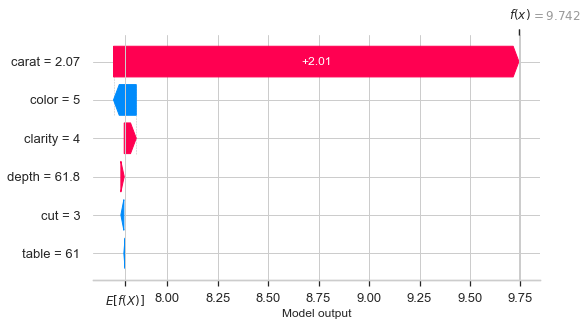


The expected value is 7.79


In [54]:
print("The original observation", X_display_train.iloc[0], sep="\n")
print("\nThe prediction walk")

shap.waterfall_plot(explainer.expected_value, shap_values[0], features=X_train.iloc[0])

print("\nThe expected value is {:.2f}".format(explainer.expected_value))

The waterfall plot is read from bottom to top: Starting with an expected value of about 7.79 log USD, the prediction is negatively impacted by its bad color. Thanks to its whopping size, the prediction is heavily increased.

### Variable importance

As bar plot, showing mean absolute contribution by feature:

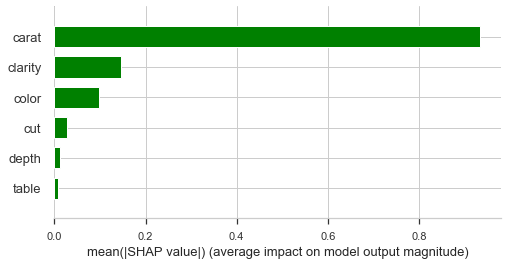

In [55]:
shap.summary_plot(shap_values, X_train[:N_SHAP], plot_type="bar", color="Green")

Not surprisingly, the most important feature is the size, followed by clarity and color.

Alternatively, we can study individual contributions:

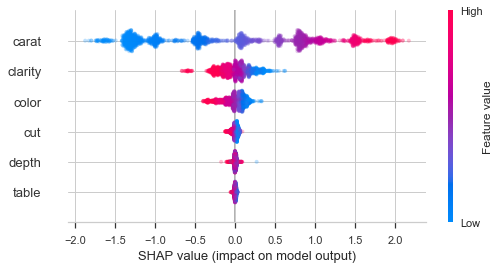

In [33]:
shap.summary_plot(shap_values, X_train[:N_SHAP], alpha=0.25)

High values for carat, low values for clarity, color and cut tend to high prices.

### Effects plots

To get an impression on the effect of a feature $X$, we plot all contributions of $X$ against $X$. They are on the centered log response scale.

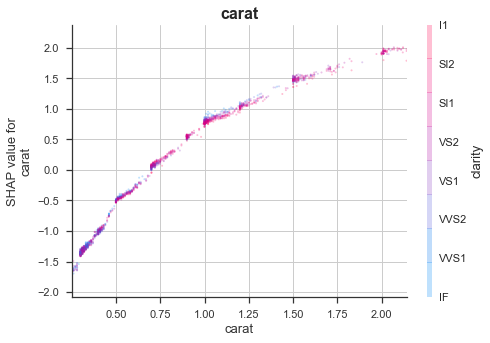

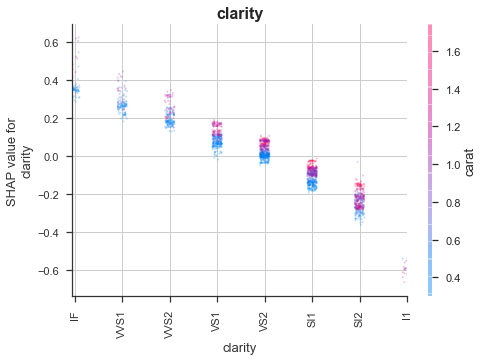

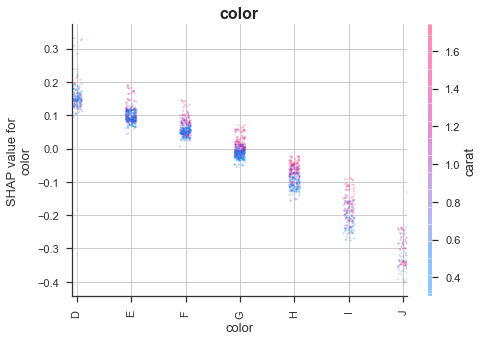

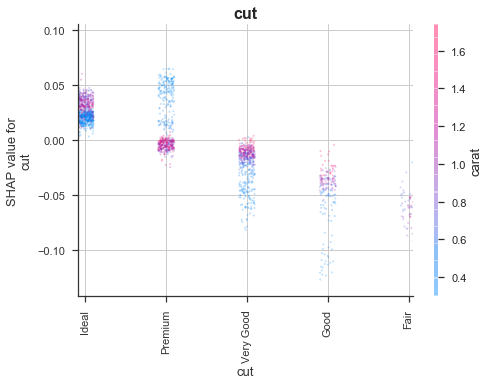

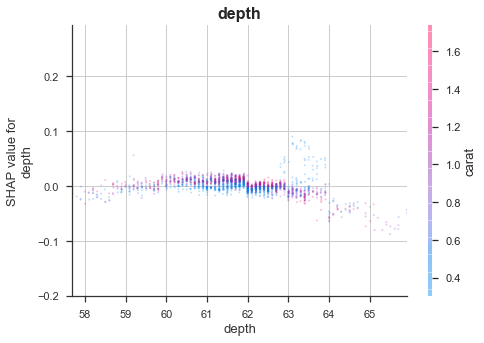

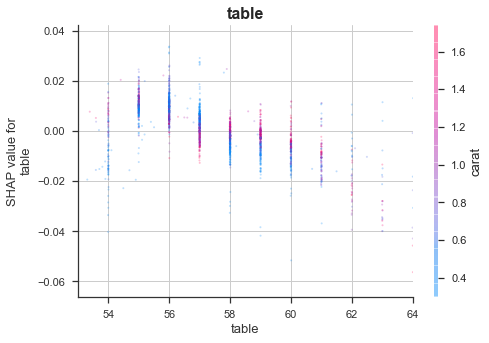

In [34]:
sorted_cols = X_train.columns[np.argsort(-np.abs(shap_values).mean(0))]

for name in sorted_cols:
    shap.dependence_plot(name, shap_values, # + explainer.expected_value, 
                         X_train[:N_SHAP], display_features=X_display_train[:N_SHAP], 
                         show=False, alpha=0.25, dot_size=4, x_jitter=0.2, 
                         xmin="percentile(1)", xmax="percentile(99)")
    plt.title(f"{name}", fontdict={'fontsize': 16, 'weight': 'bold'})
    plt.show()

### Interactions

Besides showing overall association between features and log-response, the vertical scatter in above plots indicate strong interactions. However, we do not see how much of these interactions really come from which other feature. To do so, a pairwise version of SHAP can be applied, decomposing each prediction into additive contributions from all feature pairs. Then, each of the above plots can be further decomposed. 

Calculations take $O(p)$ as long as calculating usual SHAP values, where $p$ is the number of features.

In [35]:
# Calculate N_SHAP interaction decompositions (takes 10 minutes)
shap_interaction_values = explainer.shap_interaction_values(X_train[:N_SHAP])
shap_interaction_values.shape

Variable strength decomposed into pairwise contributions:

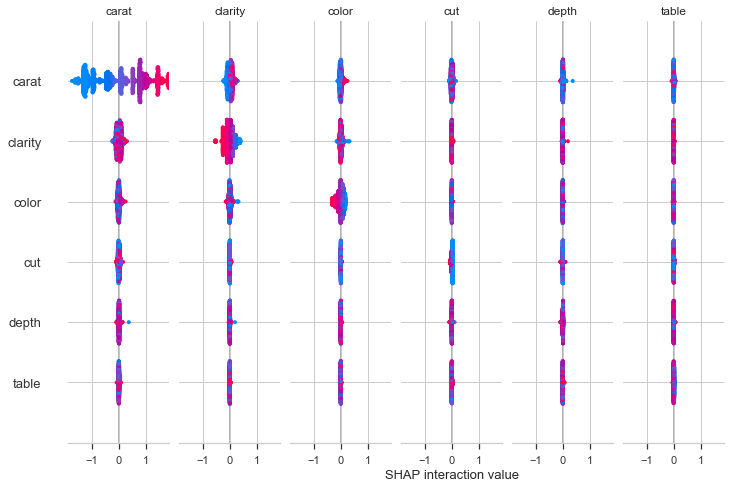

In [37]:
shap.summary_plot(shap_interaction_values, X_train[:N_SHAP], alpha=0.25)

Decomposition of dependence plots will be added later.

In [ ]:
# shap.dependence_plot("carat", shap_interaction_values, X_train[:N_SHAP])